# SQuAD v2.0 Experiments: Comparing Different Models in RAG Systems

This notebook implements two experiments with SQuAD v2.0 dataset using Retrieval-Augmented Generation (RAG):
1. RAG with a SQuAD-pretrained model: `deepset/roberta-base-squad2`
2. RAG with a general model (not pretrained on SQuAD v2.0): `bert-large-uncased-whole-word-masking-finetuned-squad`

We'll evaluate both approaches using the SQuAD validation set and compute various metrics including F1, BLEU, and ROUGE scores.

## 1. Setup and Dependencies

In [1]:
!pip install transformers datasets sentence-transformers faiss-cpu langchain langchain-community \
    nltk rouge-score sacrebleu torch spacy tqdm matplotlib seaborn

In [2]:
import os
import json
import re
from typing import List, Dict, Any, Tuple, Optional, Set
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

# Hugging Face imports
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

# LangChain imports
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import PromptTemplate

# NLP processing tools
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import stopwords
from rouge_score import rouge_scorer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Import spaCy for better tokenization
import spacy
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

2025-05-19 14:43:55.201701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747665835.224605     408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747665835.231528     408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Set seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

## 2. Loading the SQuAD Dataset

In [4]:
# Load SQuAD v2.0 dataset
dataset = load_dataset("squad_v2")
train_dataset = dataset["train"]
val_dataset = dataset["validation"]

# Load full SQuAD v2.0 training set (for creating document store)
train_dataset = load_dataset("squad_v2", split="train")
val_dataset = load_dataset("squad_v2", split="validation")

# Extract all unique contexts for document store
train_contexts = train_dataset["context"]
val_contexts = val_dataset["context"]
all_contexts = train_contexts + val_contexts

print(f"Loaded {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

Loaded 130319 training examples and 11873 validation examples


In [5]:
# Look at a sample example
sample_idx = random.randint(0, len(val_dataset) - 1)
sample = val_dataset[sample_idx]

print(f"Question: {sample['question']}")
print(f"Context: {sample['context'][:200]}...")
print(f"Answers: {sample['answers']}")

Question:  When did French Republicans back building the English empire?
Context: France took control of Algeria in 1830 but began in earnest to rebuild its worldwide empire after 1850, concentrating chiefly in North and West Africa, as well as South-East Asia, with other conquests...
Answers: {'text': [], 'answer_start': []}


Total samples: 11873
Answerable questions: 5928 (49.93%)
Unanswerable questions: 5945 (50.07%)
Average answer length: 20.92 characters
Average context length: 810.97 characters

Question types:
  what: 5674 (47.79%)
  other: 2853 (24.03%)
  how: 1110 (9.35%)
  who: 970 (8.17%)
  when: 676 (5.69%)
  where: 408 (3.44%)
  why: 182 (1.53%)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


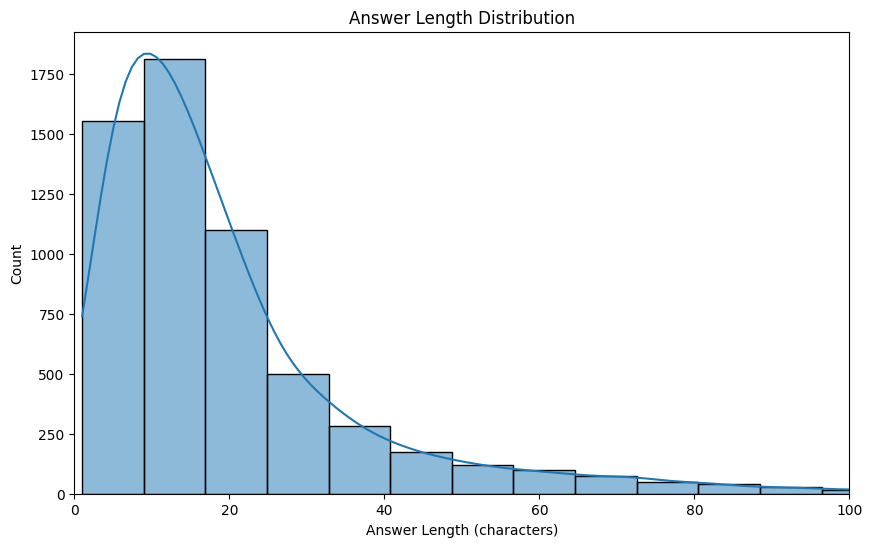

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


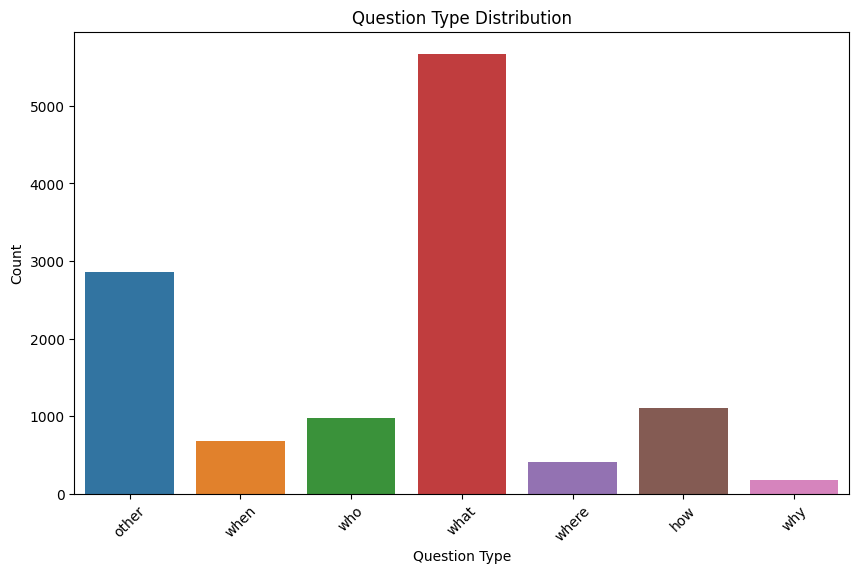

In [6]:
# Analysis of SQuAD dataset
def analyze_squad_dataset(dataset):
    total_samples = len(dataset)
    answerable_questions = sum(1 for ex in dataset if ex['answers']['text'])
    unanswerable_questions = total_samples - answerable_questions
    
    # Calculate answer lengths
    answer_lengths = [len(ex['answers']['text'][0]) for ex in dataset if ex['answers']['text']]
    avg_answer_length = sum(answer_lengths) / len(answer_lengths) if answer_lengths else 0
    
    # Calculate context lengths
    context_lengths = [len(ex['context']) for ex in dataset]
    avg_context_length = sum(context_lengths) / len(context_lengths)
    
    # Calculate question types
    question_types = Counter()
    for ex in dataset:
        question = ex['question'].lower()
        if question.startswith('what'):
            question_types['what'] += 1
        elif question.startswith('who'):
            question_types['who'] += 1
        elif question.startswith('when'):
            question_types['when'] += 1
        elif question.startswith('where'):
            question_types['where'] += 1
        elif question.startswith('why'):
            question_types['why'] += 1
        elif question.startswith('how'):
            question_types['how'] += 1
        else:
            question_types['other'] += 1
    
    # Print statistics
    print(f"Total samples: {total_samples}")
    print(f"Answerable questions: {answerable_questions} ({answerable_questions/total_samples:.2%})")
    print(f"Unanswerable questions: {unanswerable_questions} ({unanswerable_questions/total_samples:.2%})")
    print(f"Average answer length: {avg_answer_length:.2f} characters")
    print(f"Average context length: {avg_context_length:.2f} characters")
    print("\nQuestion types:")
    for q_type, count in question_types.most_common():
        print(f"  {q_type}: {count} ({count/total_samples:.2%})")
    
    # Plot answer length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(answer_lengths, bins=20, kde=True)
    plt.title('Answer Length Distribution')
    plt.xlabel('Answer Length (characters)')
    plt.ylabel('Count')
    plt.xlim(0, 100)  # Focus on answers up to 100 characters
    plt.show()
    
    # Plot question type distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(question_types.keys()), y=list(question_types.values()))
    plt.title('Question Type Distribution')
    plt.xlabel('Question Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Analyze validation set
analyze_squad_dataset(val_dataset)

## 3. Preparing Documents for Vector Store

In [7]:
# Create LangChain documents (removing duplicates for efficiency)
documents = [Document(page_content=ctx, metadata={"source": f"squad_{i}"}) 
        for i, ctx in enumerate(set(all_contexts))]
print(f"Prepared {len(documents)} unique documents from the dataset")

Prepared 20233 unique documents from the dataset


## 4. Creating the Vector Store for Semantic Search

In [30]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [9]:
# Create or load vector store
print("Creating new FAISS index...")

vector_store = FAISS.from_documents(documents, embeddings)

# Create a retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

Creating new FAISS index...


/tmp/ipykernel_408/3681611544.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


## 5. Loading and Configuring Models

In [10]:
from huggingface_hub import login

try:
    login()
except Exception as e:
    print(f"Hugging Face login failed: {e}")
    print("Please make sure you have a valid token and have accepted the model's terms on the Hugging Face website.")

In [22]:
# Model 1: SQuAD-pretrained model
squad_model_name = "deepset/roberta-base-squad2"
squad_qa_pipeline = pipeline("question-answering", model=squad_model_name, tokenizer=squad_model_name)
print(f"Loaded SQuAD-pretrained model: {squad_model_name}")

# Model 2: Alternative QA model (not pretrained on SQuAD v2.0)
general_model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
general_qa_pipeline = pipeline("question-answering", model=general_model_name)
print(f"Loaded alternative QA model (not trained on SQuAD v2.0): {general_model_name}")

Device set to use cuda:0


Loaded SQuAD-pretrained model: deepset/roberta-base-squad2


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Loaded alternative QA model (not trained on SQuAD v2.0): bert-large-uncased-whole-word-masking-finetuned-squad


## 6. Enhanced Conversation History Management

In [31]:
class ConversationManager:
    def __init__(self, max_history=5, context_weight_decay=0.8):
        self.conversation_history = []
        self.max_history = max_history
        self.context_weight_decay = context_weight_decay  # Weight decay for older contexts
    
    def add_interaction(self, question, answer, context=None, confidence=None):
        """Add a question-answer pair to the conversation history"""
        self.conversation_history.append({
            "question": question,
            "answer": answer,
            "context": context,
            "confidence": confidence,
            "timestamp": pd.Timestamp.now()
        })
        
        # Keep only the most recent exchanges
        if len(self.conversation_history) > self.max_history:
            self.conversation_history = self.conversation_history[-self.max_history:]
    
    def get_conversation_context(self, include_confidence=False):
        """Return a formatted string of the conversation history"""
        formatted_history = ""
        for exchange in self.conversation_history:
            confidence_str = f" (Confidence: {exchange['confidence']:.2f})" if include_confidence and exchange['confidence'] is not None else ""
            formatted_history += f"Q: {exchange['question']}\nA: {exchange['answer']}{confidence_str}\n\n"
        return formatted_history
    
    def get_last_exchange(self):
        """Return the last question-answer exchange"""
        if self.conversation_history:
            return self.conversation_history[-1]
        return None
    
    def get_weighted_context_history(self):
        """Return previous contexts with weights based on recency"""
        if not self.conversation_history:
            return []
            
        weighted_contexts = []
        history_length = len(self.conversation_history)
        
        for i, exchange in enumerate(self.conversation_history):
            if exchange['context']:
                # Calculate weight based on position in history (more recent = higher weight)
                weight = self.context_weight_decay ** (history_length - i - 1)
                weighted_contexts.append((exchange['context'], weight))
                
        return weighted_contexts
    
    def clear(self):
        """Clear conversation history"""
        self.conversation_history = []

## 7. Improved Context Retrieval

In [32]:
def extract_keywords(text, num_keywords=5):
    """Extract important keywords from text using spaCy"""
    # Process the text with spaCy
    doc = nlp(text)
    
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Extract potential keywords (nouns, proper nouns, etc.)
    keywords = []
    for token in doc:
        if (token.pos_ in ['NOUN', 'PROPN']) and (token.text.lower() not in stop_words) and (len(token.text) > 2):
            keywords.append(token.text)
    
    # Extract named entities too
    for ent in doc.ents:
        keywords.append(ent.text)
    
    # Count occurrences and get most common
    keyword_counts = Counter(keywords)
    return [w for w, _ in keyword_counts.most_common(num_keywords)]

def calculate_keyword_score(text, keywords):
    """Calculate a score based on keyword matches"""
    if not keywords:
        return 0
        
    score = 0
    text_lower = text.lower()
    
    for keyword in keywords:
        keyword_lower = keyword.lower()
        # Count occurrences
        occurrences = text_lower.count(keyword_lower)
        # Add to score (with diminishing returns for multiple occurrences)
        score += min(occurrences, 3) * 0.5
        
        # Bonus points for exact matches
        if keyword in text:
            score += 1
    
    return score

def mmr_rerank(documents, query, lambda_param=0.7, top_n=3):
    """Rerank documents using Maximum Marginal Relevance to balance relevance with diversity"""
    # Create embeddings for query and documents
    query_embedding = embeddings.embed_query(query)
    doc_embeddings = [embeddings.embed_query(doc.page_content) for doc in documents]
    
    # Calculate similarity between query and each document
    similarities = [np.dot(query_embedding, doc_emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_emb)) 
                    for doc_emb in doc_embeddings]
    doc_similarity_tuples = [(i, sim) for i, sim in enumerate(similarities)]
    
    # Sort by similarity
    doc_similarity_tuples.sort(key=lambda x: x[1], reverse=True)
    
    # Pick the first document
    selected = [doc_similarity_tuples[0][0]]
    remaining = doc_similarity_tuples[1:]
    
    # Rerank remaining documents using MMR
    while len(selected) < top_n and remaining:
        best_score = -np.inf
        best_idx = -1
        best_remaining_idx = -1
        
        for i, (doc_idx, sim_to_query) in enumerate(remaining):
            # Calculate maximum similarity to any already selected document
            max_sim_to_selected = max([np.dot(doc_embeddings[doc_idx], doc_embeddings[sel_idx]) / 
                                     (np.linalg.norm(doc_embeddings[doc_idx]) * np.linalg.norm(doc_embeddings[sel_idx]))
                                     for sel_idx in selected])
            
            # Calculate MMR score
            mmr_score = lambda_param * sim_to_query - (1 - lambda_param) * max_sim_to_selected
            
            if mmr_score > best_score:
                best_score = mmr_score
                best_idx = doc_idx
                best_remaining_idx = i
        
        # Add best document to selected and remove from remaining
        selected.append(best_idx)
        remaining.pop(best_remaining_idx)
    
    # Return selected documents in order
    return [documents[i] for i in selected]

def retrieve_relevant_context(question, conversation_manager=None, include_history=True, use_mmr=True, use_keywords=True):
    """Enhanced context retrieval with MMR and keyword re-ranking"""
    # Generate retrieval query from question and conversation history
    retrieval_query = question
    
    # Add context from conversation history
    if include_history and conversation_manager and conversation_manager.conversation_history:
        # Include the last exchange for continuity
        last_exchange = conversation_manager.get_last_exchange()
        if last_exchange:
            retrieval_query = f"{last_exchange['question']} {last_exchange['answer']} {question}"
    
    # Extract keywords for additional ranking
    keywords = extract_keywords(question) if use_keywords else []
    
    # Retrieve initial documents
    retrieved_docs = retriever.get_relevant_documents(retrieval_query)
    
    if not retrieved_docs:
        return None
    
    # Apply MMR reranking if enabled
    if use_mmr and len(retrieved_docs) > 1:
        retrieved_docs = mmr_rerank(retrieved_docs, question)
    
    # Apply keyword-based re-ranking if enabled
    if use_keywords and keywords:
        # Calculate keyword scores
        keyword_scores = [(doc, calculate_keyword_score(doc.page_content, keywords)) 
                         for doc in retrieved_docs]
        
        # Sort by keyword score (secondary sort)
        keyword_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Get reranked documents
        retrieved_docs = [doc for doc, _ in keyword_scores]
    
    # Extract and combine contexts
    contexts = [doc.page_content for doc in retrieved_docs]
    combined_context = " ".join(contexts)
    
    # Limit context length if needed
    max_context_length = 5000
    if len(combined_context) > max_context_length:
        combined_context = combined_context[:max_context_length]
    
    return combined_context

In [33]:
# Test the retrieval function
test_question = "Who was the leader of the Normans?"
retrieved_context = retrieve_relevant_context(test_question)
print(f"Question: {test_question}")
print(f"Retrieved context (excerpt): {retrieved_context}")

Question: Who was the leader of the Normans?
Retrieved context (excerpt): The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. The legendary religious zeal of the Normans was exercised in religious wars long before the First Crusade carved out a Norman principality in Antioch. They were major foreign particip

## 8. Improved RAG Implementations

In [74]:
class RAGWithSQuADModel:
    def __init__(self):
        self.qa_pipeline = squad_qa_pipeline
        self.model_name = squad_model_name
        self.conversation_manager = ConversationManager()
        # Model-specific confidence threshold
        self.base_confidence_threshold = 0.1
        self.answer_cache = {}  # Cache for optimization
    
    def answer_question(self, question, use_mmr=False, use_keywords=False):
        """Answer a question using RAG with SQuAD-pretrained model"""
        # Check cache first
        if question in self.answer_cache:
            return self.answer_cache[question]
            
        # Retrieve relevant context
        context = retrieve_relevant_context(question, self.conversation_manager, use_mmr, use_keywords)
        
        if not context:
            return "I couldn't find any relevant information to answer your question."

        # Incorporate conversation history into the question
        enhanced_question = question
        if self.conversation_manager.conversation_history:
            # Get the last 1-2 exchanges to provide context
            recent_history = self.conversation_manager.conversation_history if len(self.conversation_manager.conversation_history) > 1 else self.conversation_manager.conversation_history
            history_context = ""
            for exchange in recent_history:
                history_context += f"Q: {exchange['question']}\nA: {exchange['answer']}\n"
            # Prepend history to the question
            enhanced_question = f"{history_context}\nQ: {question}"

        # Process with the model using the enhanced question
        result = self.qa_pipeline(question=enhanced_question, context=context)
        
        # Rest of method remains the same
        answer = result["answer"]
        score = result["score"]
        
        # Dynamic confidence threshold based on answer length
        confidence_threshold = self.base_confidence_threshold
        if len(answer) < 3:  # Very short answers need higher confidence
            confidence_threshold *= 1.5
        
        # Handle low confidence answers
        if score < confidence_threshold or not answer.strip():
            answer = "I'm not confident in my answer based on the available information."
        
        # Update conversation history
        self.conversation_manager.add_interaction(question, answer, context, score)
        
        # Cache the answer
        self.answer_cache[question] = answer
        
        return answer
    
    def get_answer_with_confidence(self, question, use_mmr=False, use_keywords=False):
        """Return both answer and confidence score"""
        # Retrieve relevant context
        context = retrieve_relevant_context(question, self.conversation_manager, use_mmr, use_keywords)
        
        if not context:
            return "I couldn't find any relevant information to answer your question.", 0.0
        
        # Process with the SQuAD-pretrained model
        result = self.qa_pipeline(question=question, context=context)
        
        return result["answer"], result["score"]
    
    def clear_history(self):
        """Clear conversation history"""
        self.conversation_manager.clear()
        self.answer_cache = {}

In [75]:
class RAGWithGeneralModel:
    def __init__(self):
        self.qa_pipeline = general_qa_pipeline
        self.model_name = general_model_name
        self.conversation_manager = ConversationManager()
        # Model-specific confidence threshold (potentially different from SQuAD model)
        self.base_confidence_threshold = 0.15  # Slightly higher threshold for this model
        self.answer_cache = {}  # Cache for optimization
    
    def answer_question(self, question, use_mmr=False, use_keywords=False):
        """Answer a question using RAG with SQuAD-pretrained model"""
        # Check cache first
        if question in self.answer_cache:
            return self.answer_cache[question]
            
        # Retrieve relevant context
        context = retrieve_relevant_context(question, self.conversation_manager, use_mmr, use_keywords)
        
        if not context:
            return "I couldn't find any relevant information to answer your question."

        # Incorporate conversation history into the question
        enhanced_question = question
        if self.conversation_manager.conversation_history:
            # Get the last 1-2 exchanges to provide context
            recent_history = self.conversation_manager.conversation_history if len(self.conversation_manager.conversation_history) > 1 else self.conversation_manager.conversation_history
            history_context = ""
            for exchange in recent_history:
                history_context += f"Q: {exchange['question']}\nA: {exchange['answer']}\n"
            # Prepend history to the question
            enhanced_question = f"{history_context}\nQ: {question}"

        # Process with the model using the enhanced question
        result = self.qa_pipeline(question=enhanced_question, context=context)
        
        # Rest of method remains the same
        answer = result["answer"]
        score = result["score"]
        
        # Dynamic confidence threshold based on answer length
        confidence_threshold = self.base_confidence_threshold
        if len(answer) < 3:  # Very short answers need higher confidence
            confidence_threshold *= 1.5
        
        # Handle low confidence answers
        if score < confidence_threshold or not answer.strip():
            answer = "I'm not confident in my answer based on the available information."
        
        # Update conversation history
        self.conversation_manager.add_interaction(question, answer, context, score)
        
        # Cache the answer
        self.answer_cache[question] = answer
        
        return answer
    
    def get_answer_with_confidence(self, question, use_mmr=False, use_keywords=False):
        """Return both answer and confidence score"""
        # Retrieve relevant context
        context = retrieve_relevant_context(question, self.conversation_manager, use_mmr, use_keywords)
        
        if not context:
            return "I couldn't find any relevant information to answer your question.", 0.0
        
        # Process with the general model
        result = self.qa_pipeline(question=question, context=context)
        
        return result["answer"], result["score"]
    
    def clear_history(self):
        """Clear conversation history"""
        self.conversation_manager.clear()
        self.answer_cache = {}

## 9. Enhanced Evaluation Metrics

In [36]:
def improved_compute_f1_score(prediction, ground_truth):
    """Compute F1 score between prediction and ground truth"""
    if not ground_truth and not prediction:
        return 1.0
    if not ground_truth or not prediction:
        return 0.0
    
    # Use spaCy for better tokenization
    pred_doc = nlp(prediction.lower())
    truth_doc = nlp(ground_truth.lower())
    
    pred_tokens = [token.text for token in pred_doc if not token.is_punct and not token.is_stop]
    truth_tokens = [token.text for token in truth_doc if not token.is_punct and not token.is_stop]
    
    # Calculate precision, recall, and F1
    common = set(pred_tokens) & set(truth_tokens)
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(truth_tokens) if truth_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

def improved_compute_metrics(prediction, ground_truth):
    """Compute various metrics between prediction and ground truth"""
    # ROUGE scores
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(prediction, ground_truth)
    
    # BLEU score with smoothing
    pred_doc = nlp(prediction.lower())
    truth_doc = nlp(ground_truth.lower())
    
    pred_tokens = [token.text for token in pred_doc if not token.is_punct]
    truth_tokens = [[token.text for token in truth_doc if not token.is_punct]]
    
    # Use smoothing function for BLEU and lower n-gram weights for short texts
    smoothie = SmoothingFunction().method1
    weights = (0.5, 0.3, 0.1, 0.1)  # Give more weight to unigrams & bigrams
    
    bleu_score = sentence_bleu(truth_tokens, pred_tokens, 
                              weights=weights,
                              smoothing_function=smoothie) if pred_tokens else 0
    
    # F1 score
    f1 = improved_compute_f1_score(prediction, ground_truth)
    
    # Semantic similarity using sentence-transformers
    similarity_score = compute_semantic_similarity(prediction, ground_truth)
    
    # Answer exact match
    exact_match = 1.0 if prediction.lower() == ground_truth.lower() else 0.0
    
    return {
        'f1': f1,
        'bleu': bleu_score,
        'rouge1_f1': rouge_scores['rouge1'].fmeasure,
        'rouge2_f1': rouge_scores['rouge2'].fmeasure,
        'rougeL_f1': rouge_scores['rougeL'].fmeasure,
        'semantic_similarity': similarity_score,
        'exact_match': exact_match
    }

def compute_semantic_similarity(text1, text2):
    """Compute semantic similarity between two texts using sentence embeddings"""    
    # Get embeddings
    emb1 = embeddings.embed_query(text1)
    emb2 = embeddings.embed_query(text2)
    
    # Calculate cosine similarity
    similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    
    return similarity

In [37]:
def filter_valid_examples(dataset, max_samples=50, include_unanswerable=False):
    """Filter examples from the dataset for evaluation"""
    valid_examples = []
    unanswerable_count = 0
    answerable_count = 0
    max_unanswerable = max_samples // 4 if include_unanswerable else 0  # 25% unanswerable if included
    
    # Random shuffling for better sampling
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    for idx in indices:
        ex = dataset[idx]
        
        # Check if there is at least one answer
        if ex['answers']['text']:
            if answerable_count < (max_samples - max_unanswerable):
                valid_examples.append({
                    'question': ex['question'],
                    'context': ex['context'],
                    'answer': ex['answers']['text'][0],  # Take the first answer
                    'has_answer': True
                })
                answerable_count += 1
        elif include_unanswerable and unanswerable_count < max_unanswerable:
            valid_examples.append({
                'question': ex['question'],
                'context': ex['context'],
                'answer': "",  # Empty answer for unanswerable questions
                'has_answer': False
            })
            unanswerable_count += 1
        
        if answerable_count >= (max_samples - max_unanswerable) and unanswerable_count >= max_unanswerable:
            break
    
    print(f"Selected {len(valid_examples)} evaluation examples")
    print(f"  - Answerable: {answerable_count}")
    print(f"  - Unanswerable: {unanswerable_count}")
    
    return valid_examples

## 10. Run Experiments

In [38]:
# Select validation examples
validation_examples = filter_valid_examples(val_dataset, max_samples=100, include_unanswerable=True)

Selected 100 evaluation examples
  - Answerable: 75
  - Unanswerable: 25


In [68]:
# Initialize both systems
squad_model_system = RAGWithSQuADModel()
general_model_system = RAGWithGeneralModel()

In [69]:
def evaluate_models(examples, squad_model_system, general_model_system):
    """Simplified evaluation function - processes one example at a time"""
    results = []
    
    for i, example in enumerate(tqdm(examples, desc="Evaluating")):
        # Get basic example information
        question = example['question']
        ground_truth = example['answer']
        has_answer = example['has_answer']
        
        # Get answers from both models
        squad_answer, squad_confidence = squad_model_system.get_answer_with_confidence(question, use_mmr=False, use_keywords=False)
        general_answer, general_confidence = general_model_system.get_answer_with_confidence(question, use_mmr=False, use_keywords=False)
        
        # Process results based on whether question has an answer
        if not has_answer:
            # For unanswerable questions
            squad_correct = "I'm not confident" in squad_answer.lower() or squad_confidence < squad_model_system.base_confidence_threshold
            general_correct = "I'm not confident" in general_answer.lower() or general_confidence < general_model_system.base_confidence_threshold

            result = {
                'question': question,
                'ground_truth': ground_truth,
                'has_answer': has_answer,
                'squad_model': {
                    'answer': squad_answer,
                    'confidence': squad_confidence,
                    'correct': squad_correct,
                    'metrics': {'f1': 1.0 if squad_correct else 0.0}
                },
                'general_model': {
                    'answer': general_answer,
                    'confidence': general_confidence,
                    'correct': general_correct,
                    'metrics': {'f1': 1.0 if general_correct else 0.0}
                }
            }
        else:
            # For answerable questions
            squad_metrics = improved_compute_metrics(squad_answer, ground_truth) if squad_answer else {'f1': 0, 'bleu': 0, 'rouge1_f1': 0, 'rouge2_f1': 0, 'rougeL_f1': 0, 'semantic_similarity': 0, 'exact_match': 0}
            general_metrics = improved_compute_metrics(general_answer, ground_truth) if general_answer else {'f1': 0, 'bleu': 0, 'rouge1_f1': 0, 'rouge2_f1': 0, 'rougeL_f1': 0, 'semantic_similarity': 0, 'exact_match': 0}
            
            result = {
                'question': question,
                'ground_truth': ground_truth,
                'has_answer': has_answer,
                'squad_model': {
                    'answer': squad_answer,
                    'confidence': squad_confidence,
                    'metrics': squad_metrics
                },
                'general_model': {
                    'answer': general_answer,
                    'confidence': general_confidence,
                    'metrics': general_metrics
                }
            }
        
        results.append(result)

        squad_model_system.clear_history()
        general_model_system.clear_history()
        
        # Save progress every 10 examples
        if (i + 1) % 10 == 0:
            with open('experiment_results_models_improved.json', 'w') as f:
                json.dump(results, f, indent=2)
    
    # Save final results
    with open('experiment_results_models_improved.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    return results

In [41]:
# Run experiments (uncomment to execute)
experiment_results = evaluate_models(validation_examples, squad_model_system, general_model_system)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Load results if already computed
if os.path.exists('experiment_results_models_improved.json'):
    with open('experiment_results_models_improved.json', 'r') as f:
        experiment_results = json.load(f)
    print(f"Loaded {len(experiment_results)} experiment results")

## 11. Enhanced Results Analysis

In [42]:
def analyze_experiment_results(results):
    """Enhanced analysis of experiment results"""
    # Initialize counters
    total_examples = len(results)
    answerable_examples = sum(1 for r in results if r['has_answer'])
    unanswerable_examples = total_examples - answerable_examples
    
    # Initialize metric accumulators
    metrics = {
        'squad': defaultdict(list),
        'general': defaultdict(list)
    }
    
    # Analyze per question type
    question_types = defaultdict(lambda: {'squad': [], 'general': []})
    
    # Error analysis categories
    error_categories = {
        'squad': defaultdict(int),
        'general': defaultdict(int)
    }
    
    # Collect metrics and errors for analysis
    for result in results:
        # Skip unanswerable questions for some analyses
        if not result['has_answer']:
            # Track no-answer detection accuracy
            for model_key, model_name in [("squad_model", "squad"), ("general_model", "general")]:
                if result[model_key]['correct']:
                    metrics[model_name]['no_answer_accuracy'].append(1)
                else:
                    metrics[model_name]['no_answer_accuracy'].append(0)
                    error_categories[model_name]['false_positive'] += 1
            continue
        
        # Determine question type
        question = result['question'].lower()
        q_type = 'other'
        for prefix in ['what', 'who', 'when', 'where', 'why', 'how']:
            if question.startswith(prefix):
                q_type = prefix
                break
        
        # Collect metrics by model
        for model_key, model_name in [("squad_model", "squad"), ("general_model", "general")]:
            model_result = result[model_key]
            model_metrics = model_result['metrics']
            
            # Track all metrics
            for metric_name, metric_value in model_metrics.items():
                metrics[model_name][metric_name].append(metric_value)
            
            # Track by question type
            question_types[q_type][model_name].append(model_metrics['f1'])
            
            # Error analysis
            if model_metrics['f1'] < 0.5:  # Consider it an error if F1 < 0.5
                # Categorize error
                answer = model_result['answer']
                confidence = model_result['confidence']
                
                if 'not confident' in answer.lower():
                    error_categories[model_name]['low_confidence'] += 1
                elif confidence < 0.3:
                    error_categories[model_name]['uncertain'] += 1
                elif len(answer) < 3:
                    error_categories[model_name]['too_short'] += 1
                elif model_metrics['semantic_similarity'] > 0.7 and model_metrics['f1'] < 0.3:
                    error_categories[model_name]['semantic_match_lexical_mismatch'] += 1
                else:
                    error_categories[model_name]['incorrect_extraction'] += 1
    
    # Calculate average metrics
    squad_avg_metrics = {metric: np.mean(values) for metric, values in metrics['squad'].items() if values}
    general_avg_metrics = {metric: np.mean(values) for metric, values in metrics['general'].items() if values}
    
    # Calculate question type performance
    q_type_performance = {}
    for q_type, models in question_types.items():
        q_type_performance[q_type] = {
            'squad': np.mean(models['squad']) if models['squad'] else 0,
            'general': np.mean(models['general']) if models['general'] else 0,
            'count': len(models['squad'])
        }
    
    # Perform t-test to check if difference is statistically significant
    import scipy.stats as stats
    t_stat, p_value = stats.ttest_ind(metrics['squad']['f1'], metrics['general']['f1'], equal_var=False)
    is_significant = p_value < 0.05
    
    # Print summary
    print(f"Total examples: {total_examples}")
    print(f"Answerable questions: {answerable_examples}")
    print(f"Unanswerable questions: {unanswerable_examples}")
    print("\nAverage Metrics:")
    print("SQuAD Model:")
    for metric, value in squad_avg_metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("\nGeneral Model:")
    for metric, value in general_avg_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\nStatistical significance (F1 score): p-value = {p_value:.4f} {'(significant)' if is_significant else '(not significant)'}")
    
    print("\nPerformance by Question Type:")
    for q_type, perf in sorted(q_type_performance.items(), key=lambda x: x[1]['count'], reverse=True):
        print(f"  {q_type} ({perf['count']} questions): Squad F1 = {perf['squad']:.4f}, General F1 = {perf['general']:.4f}")
    
    print("\nError Analysis:")
    print("SQuAD Model Errors:")
    for category, count in sorted(error_categories['squad'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {count} ({count/answerable_examples:.1%})")
    print("\nGeneral Model Errors:")
    for category, count in sorted(error_categories['general'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {count} ({count/answerable_examples:.1%})")
    
    # Plot performance comparison
    metrics_to_plot = ['f1', 'bleu', 'rouge1_f1', 'rougeL_f1', 'semantic_similarity']
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    squad_values = [squad_avg_metrics.get(m, 0) for m in metrics_to_plot]
    general_values = [general_avg_metrics.get(m, 0) for m in metrics_to_plot]
    
    plt.bar(x - width/2, squad_values, width, label='SQuAD Model')
    plt.bar(x + width/2, general_values, width, label='General Model')
    
    plt.xticks(x, metrics_to_plot)
    plt.ylabel('Score')
    plt.title('Performance Comparison by Metric')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot performance by question type
    plt.figure(figsize=(12, 6))
    q_types = [q for q, _ in sorted(q_type_performance.items(), key=lambda x: x[1]['count'], reverse=True)]
    x = np.arange(len(q_types))
    
    squad_by_type = [q_type_performance[q]['squad'] for q in q_types]
    general_by_type = [q_type_performance[q]['general'] for q in q_types]
    
    plt.bar(x - width/2, squad_by_type, width, label='SQuAD Model')
    plt.bar(x + width/2, general_by_type, width, label='General Model')
    
    plt.xticks(x, q_types)
    plt.ylabel('F1 Score')
    plt.title('Performance by Question Type')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return calculated metrics for further use
    return {
        'overview': {
            'total': total_examples,
            'answerable': answerable_examples,
            'unanswerable': unanswerable_examples
        },
        'metrics': {
            'squad': squad_avg_metrics,
            'general': general_avg_metrics
        },
        'by_question_type': q_type_performance,
        'error_analysis': error_categories,
        'statistical_significance': {
            't_stat': t_stat,
            'p_value': p_value,
            'is_significant': is_significant
        }
    }


Total examples: 100
Answerable questions: 75
Unanswerable questions: 25

Average Metrics:
SQuAD Model:
  f1: 0.7236
  bleu: 0.3557
  rouge1_f1: 0.7128
  rouge2_f1: 0.3584
  rougeL_f1: 0.7128
  semantic_similarity: 0.7691
  exact_match: 0.5200
  no_answer_accuracy: 0.6800

General Model:
  f1: 0.7234
  bleu: 0.3797
  rouge1_f1: 0.7090
  rouge2_f1: 0.4054
  rougeL_f1: 0.7090
  semantic_similarity: 0.7848
  exact_match: 0.5733
  no_answer_accuracy: 0.0400

Statistical significance (F1 score): p-value = 0.9982 (not significant)

Performance by Question Type:
  what (36 questions): Squad F1 = 0.7874, General F1 = 0.7127
  other (22 questions): Squad F1 = 0.6571, General F1 = 0.7212
  how (5 questions): Squad F1 = 0.7467, General F1 = 0.7467
  when (4 questions): Squad F1 = 0.7500, General F1 = 1.0000
  where (4 questions): Squad F1 = 0.7500, General F1 = 0.7500
  who (3 questions): Squad F1 = 0.2444, General F1 = 0.3333
  why (1 questions): Squad F1 = 1.0000, General F1 = 1.0000

Error Anal

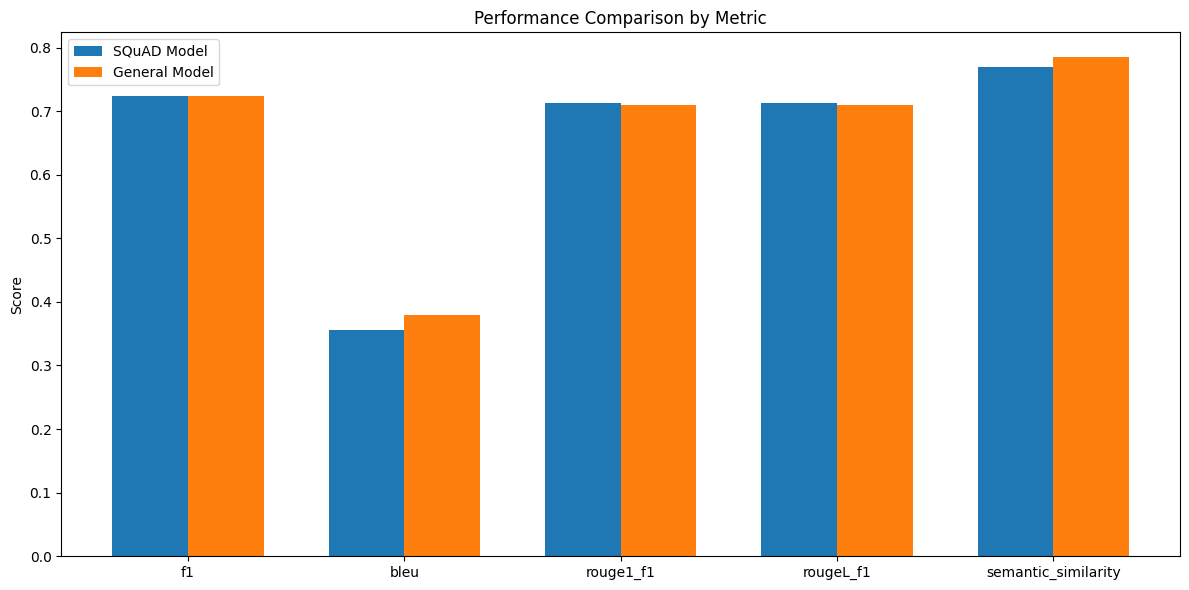

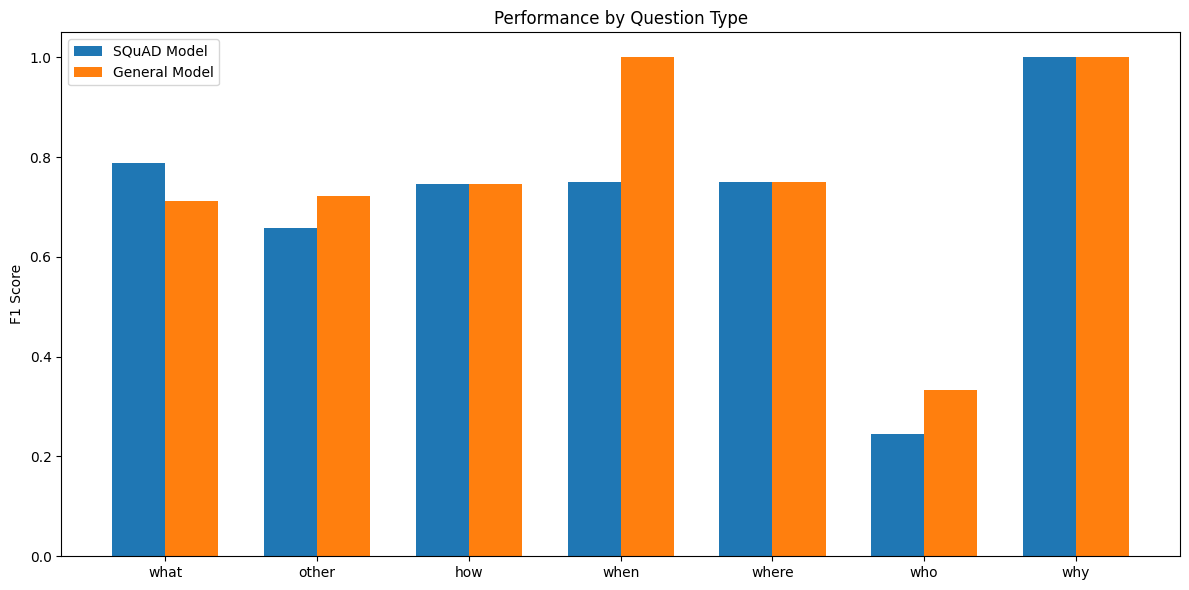

In [43]:
# Run enhanced analysis
analysis_results = analyze_experiment_results(experiment_results)

In [44]:
# Export analysis results
with open('analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

TypeError: Object of type bool_ is not JSON serializable

## 12. Interactive Chat Demo

In [76]:
def highlight_text(text, keywords, color='gray'):
    """Highlight keywords in text for display in the chat interface"""
    import html
    
    # Escape HTML
    escaped_text = html.escape(text)
    
    # Highlight keywords with HTML
    for keyword in keywords:
        if not keyword or len(keyword) < 3:
            continue
            
        # Highlight preserving case
        pattern = re.compile(re.escape(keyword), re.IGNORECASE)
        replacement = f'<span style="background-color: {color};">{{}}</span>'
        
        def replace_match(match):
            return replacement.format(match.group(0))
            
        escaped_text = pattern.sub(replace_match, escaped_text)
    
    return escaped_text

def interactive_compare_models_chat():
    """Enhanced interactive chat demo comparing both models with visualization"""
    print("Welcome to the Enhanced SQuAD RAG Chatbot!")
    print("Ask questions to compare both models, or type 'exit' to quit.")
    print("Available commands:")
    print("  'history' - Show conversation history")
    print("  'confidence' - Toggle showing confidence scores")
    print("  'context' - Toggle showing retrieved context")
    print("  'highlight' - Toggle highlighting keywords in context")
    print("  'exit' - Exit the chat")
    
    # Initialize both systems
    squad_system = RAGWithSQuADModel()
    bert_system = RAGWithGeneralModel()
    
    # UI state
    show_confidence = True
    show_context = False
    highlight_keywords = True
    
    while True:
        question = input("\nYou: ")
        question = question.strip()
        
        if question.lower() == 'exit':
            print("Goodbye!")
            break
            
        if question.lower() == 'history':
            squad_history = squad_system.conversation_manager.get_conversation_context(include_confidence=show_confidence)
            if squad_history:
                print("\nSQuAD Model Conversation History:")
                print(squad_history)
            else:
                print("No SQuAD model conversation history yet.")
            
            bert_history = bert_system.conversation_manager.get_conversation_context(include_confidence=show_confidence)
            if bert_history:
                print("\nBERT Model Conversation History:")
                print(bert_history)
            else:
                print("No BERT model conversation history yet.")
            continue
        
        if question.lower() == 'confidence':
            show_confidence = not show_confidence
            print(f"Confidence scores {'will now be shown' if show_confidence else 'will not be shown'}")
            continue
            
        if question.lower() == 'context':
            show_context = not show_context
            print(f"Context {'will now be shown' if show_context else 'will not be shown'}")
            continue
        
        if question.lower() == 'highlight':
            highlight_keywords = not highlight_keywords
            print(f"Keyword highlighting {'enabled' if highlight_keywords else 'disabled'}")
            continue
        
        # Extract keywords for highlighting
        keywords = extract_keywords(question) if highlight_keywords else []
        
        # Get contexts and answers from both systems
        squad_context = retrieve_relevant_context(question, squad_system.conversation_manager)
        bert_context = retrieve_relevant_context(question, bert_system.conversation_manager)
        
        # Get answers and confidence scores
        squad_answer, squad_confidence = squad_system.get_answer_with_confidence(question)
        bert_answer, bert_confidence = bert_system.get_answer_with_confidence(question)
        
        # Update conversation histories
        squad_system.conversation_manager.add_interaction(question, squad_answer, squad_context, squad_confidence)
        bert_system.conversation_manager.add_interaction(question, bert_answer, bert_context, bert_confidence)
        
        # Display results
        print("\n" + "="*80)
        print(f"SQuAD Model Answer: {squad_answer}")
        if show_confidence:
            print(f"Confidence: {squad_confidence:.4f}")
        
        if show_context and squad_context:
            print("\nRetrieved Context:")
            if highlight_keywords and keywords:
                # Show highlighted context using HTML
                highlighted_context = highlight_text(squad_context[:700] + "...", keywords)
                display(HTML(f"<div style='background-color: #000000; padding: 10px; border-radius: 5px;'>{highlighted_context}</div>"))
            else:
                print(f"{squad_context[:700]}...")
        
        print("\n" + "-"*80)
        print(f"BERT Model Answer: {bert_answer}")
        if show_confidence:
            print(f"Confidence: {bert_confidence:.4f}")
            
        if show_context and bert_context:
            print("\nRetrieved Context:")
            if highlight_keywords and keywords:
                # Show highlighted context using HTML
                highlighted_context = highlight_text(bert_context[:700] + "...", keywords)
                display(HTML(f"<div style='background-color: #000000; padding: 10px; border-radius: 5px;'>{highlighted_context}</div>"))
            else:
                print(f"{bert_context[:700]}...")
                
        print("="*80)
        
        # If answers are significantly different, analyze why
        if squad_answer != bert_answer and 'not confident' not in squad_answer.lower() and 'not confident' not in bert_answer.lower():
            # Calculate similarity
            similarity = compute_semantic_similarity(squad_answer, bert_answer)
            if similarity < 0.7:
                print("\nThe answers from the two models differ significantly.")
                print(f"Semantic similarity between answers: {similarity:.4f}")
                
                # Analyze possible reasons
                reasons = []
                
                if abs(squad_confidence - bert_confidence) > 0.3:
                    reasons.append("Significant difference in confidence scores")
                    
                if squad_context != bert_context:
                    reasons.append("Different contexts were retrieved for each model")
                    
                # Special case: if one answer is very short
                if len(squad_answer) < 5 or len(bert_answer) < 5:
                    reasons.append("One model provided a very short answer")
                    
                if reasons:
                    print("Possible reasons for different answers:")
                    for i, reason in enumerate(reasons, 1):
                        print(f"  {i}. {reason}")
        
    # Clear conversation histories when done
    squad_system.clear_history()
    bert_system.clear_history()

In [79]:
interactive_compare_models_chat()

Welcome to the Enhanced SQuAD RAG Chatbot!
Ask questions to compare both models, or type 'exit' to quit.
Available commands:
  'history' - Show conversation history
  'confidence' - Toggle showing confidence scores
  'context' - Toggle showing retrieved context
  'highlight' - Toggle highlighting keywords in context
  'exit' - Exit the chat



You:  Who did Beyonce marry?



SQuAD Model Answer: Jay Z
Confidence: 0.9112

--------------------------------------------------------------------------------
BERT Model Answer: Jay Z
Confidence: 0.9597



You:  Together how records have they sold?



SQuAD Model Answer: more than 300 million
Confidence: 0.2415

--------------------------------------------------------------------------------
BERT Model Answer: 118 million
Confidence: 0.1833



You:  When did they get married?



SQuAD Model Answer: April 4, 2008
Confidence: 0.8201

--------------------------------------------------------------------------------
BERT Model Answer: April 4, 2008
Confidence: 0.9385



You:  exit


Goodbye!
